<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

<center>
<h1>Workshop: Genetic Association Studies</h1><br><br>
<i><big>Performing a quantitative trait genome-wide association study: from data preparation to analysis of results.</big><br><br>
originally written by Sophie Hackinger, Kostas Hatzikotoulas and Arthur Gilly</i>
</center>

## Objectives
In this workshop you will learn the basic skills needed to perform genetic association studies, from file format manipulation to filtering, single-point association and visualisation of results. We will be working with a simulated  phenotype (let's say it's a blood metabolite measurement).
<br><br>

<figure>
  <img src="./WS3_workflow.png" width="60%" alt="" />
  <figcaption><i><center>Fig. 1: Workflow of the different analysis stages covered in the workshop</center></i></figcaption>
</figure>

<br><br>

We will be using <code>plink</code> to run the association and R to standardise our phenotype and visualise the results.
You can find a manual and command reference of <code>plink</code> [here](https://www.cog-genomics.org/plink/1.9/).

In R we will be using the package <code>data.table</code>, which provides a lot of useful commands, such as <code>fread</code> for fast reading in of large files. If you want to find out more about <code>data.table</code> and its perks, you can do so [here](https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html) and [here](https://cran.r-project.org/web/packages/data.table/data.table.pdf).

<br>

<div class="alert alert-warning">
<b>Location:</b> The workshop is organised in three steps: file preparation, analysis and visualisation. We've created a `data` folder, where you can find three directories with the files you need for each step.
</div>

<div class="alert alert-warning">
<b>Location:</b> We've included buttons to show/hide the commands so that you can try and solve the questions yourself, but they won't show if you run the notebook in Binder. To enable them you have to view the notebook as a static webpage <a href="https://nbviewer.jupyter.org/github/hmgu-itg/teaching_binder/blob/master/Workshop.ipynb?flush_cache=true">by clicking on this link</a>.
</div>


<hr>

## Step 1: File preparation

<br>
<div class="alert alert-warning">
<b>Location:</b> Input files for this step are located in the <code>Step1</code> folder.
</div>

<br>


### Missing phenotypes  


In large-scale sample collections you will often find that some individuals do not have a data entry for your phenotype of interest.

This is normally not a problem, as long as it doesn't affect too many samples. Association programs like <code>plink</code> and <code>SNPTEST</code> treat certain values (usually NA or -9) as missing phenotypes and exclude the corresponding samples automatically.

Nevertheless, it is good practice to check how many samples have missing phenotypes before running an association, and also make sure that their phenotype is set to an accepted missing value.

<br>

<div class="alert alert-success"><b>Question 1:</b>  In the <code>Step1</code> folder you will find a file called <code>cohort1_pheno.txt</code> containing sample IDs and phenotype values. Using the command line, count the number of "NA" phenotypes.</div>

<br>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show answer</button>



In [1]:
cd data
ls

Step1  Step2  Step3


In [2]:
cd Step1
ls


cohort1_pheno.txt


In [3]:
head cohort1_pheno.txt

HG00096	0.524833281418885
HG00097	0.740450051771972
HG00099	0.7690246541258
HG00100	0.00320711064321361
HG00101	0.999959897040246
HG00102	0.454647523948369
HG00103	0.877078409389809
HG00105	0.982802868251181
HG00106	0.816957472802316
HG00107	0.55474476129905


Here, our file is organised in two columns: 1) sample ID and 2) phenotype value. Let's see if we have missing values:

In [4]:

awk '$2=="NA"{print}' cohort1_pheno.txt | wc -l

# alternatively, you can use grep
grep 'NA$' cohort1_pheno.txt | wc -l


5
5


### Phenotype cleaning and standardisation

When working with quantitative traits, such as height, BMI or blood lipids, you will often find that the measurements in your cohort do not follow a normal distribution. This could simply be due to the way your samples were collected - e.g. height follows an approximately normal distrbution at the population level; however, if you randomly pick 100 people, you might end up with a skewed distribution, simply because by chance there is a disproportionate number of very tall people in your sample.
On the other hand, some traits naturally follow a non-normal distribution, such as certain blood metabolites.

Since linear regression models rely on the assumption of a normally distributed response variable (the phenotype), it is important to inspect your phenotype measurements and, if necessary, standardise them before conducting a GWAS.

<br>

<div class="alert alert-success"><b>Question 2:</b>  Load the <code>cohort1_pheno.txt</code> file in R and look at the distribution of the phenotype values. How might you visualise this? Are there any outliers?</div>

<br>

<div class="alert alert-danger">Beware, now we are going to use R. Switch the kernel in the Kernel menu before proceeding, otherwise you will get errors.</div>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show answer</button>

In [1]:
.libPaths(c("/home/jovyan/R/packages", .libPaths()))

In [3]:
setwd("Step1")

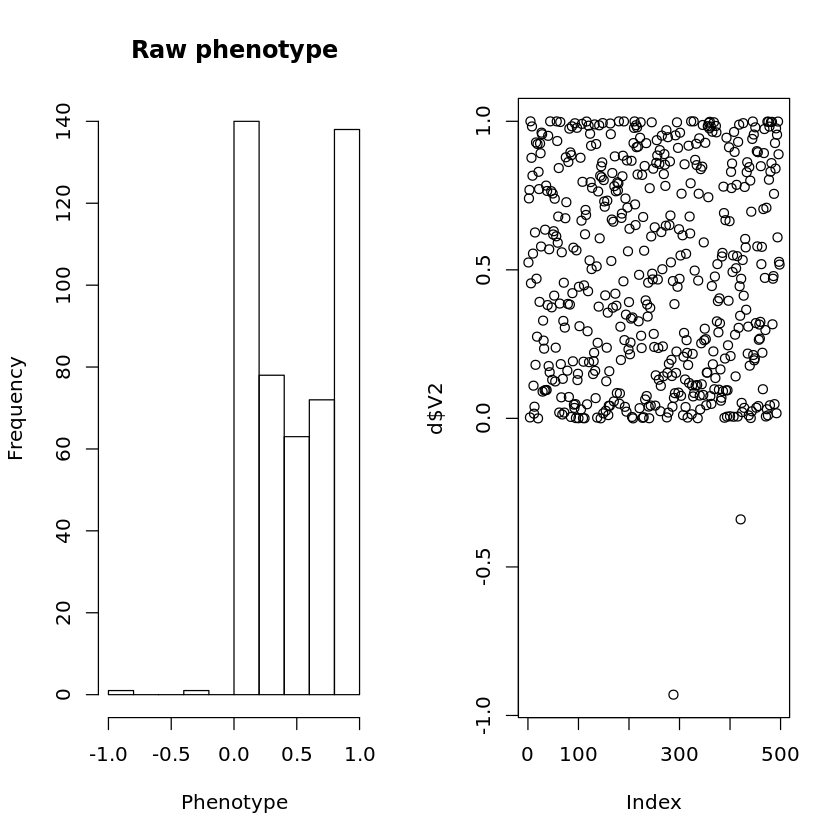

In [4]:
library(data.table)
d=fread("cohort1_pheno.txt")
par(mfrow=c(1,2))
hist(d$V2, xlab="Phenotype", main="Raw phenotype")
plot(d$V2)

From the plot you can see that there are outlier phenotype measurements in the negative range, which we will exclude. 
Depending on the type of trait you are looking at, you will have different criteria for outlier definition. For phsyiological or anthropometric measurements it is a good rule of thumb to look for negative values or ones that are biologically impossible (for example, it's highly unlikely to find someone who is 900m tall!)

Next, we want to exclude the outliers and re-examine the phenotype distribution.

These steps can again be performed in R:

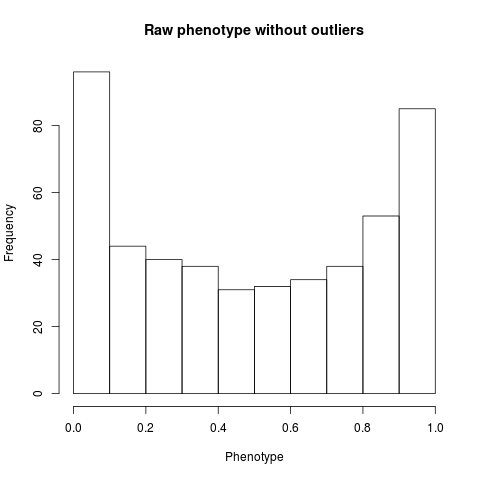

In [7]:
# set outliers to NA
d[V2<0,V2:=NA]

# re-examine distribution
hist(d$V2,xlab="Phenotype", main="Raw phenotype without outliers")


<br>

<div class="alert alert-success"><b>Question 3:</b>  What distribution does the phenotype follow? Can you come up with a way to transform this distribution to a standard normal one?</div>

<br>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show answer</button>

In [5]:
## The phenotype does not seem to follow any known distribution. It is symmetric, probably non-skewed, non-normal, non-uniform.

## Let's try a few transforms

Warning message in log(d$V2):
“NaNs produced”Warning message in sqrt(d$V2):
“NaNs produced”

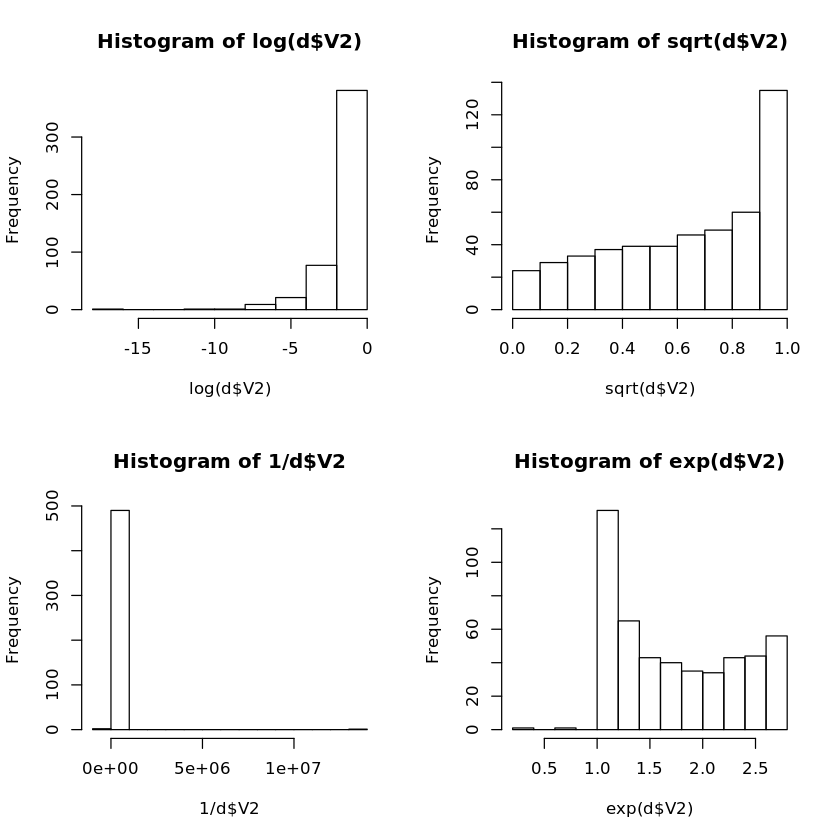

In [12]:
par(mfrow=c(2,2))
hist(log(d$V2))
hist(sqrt(d$V2))
hist(1/d$V2)
hist(exp(d$V2))

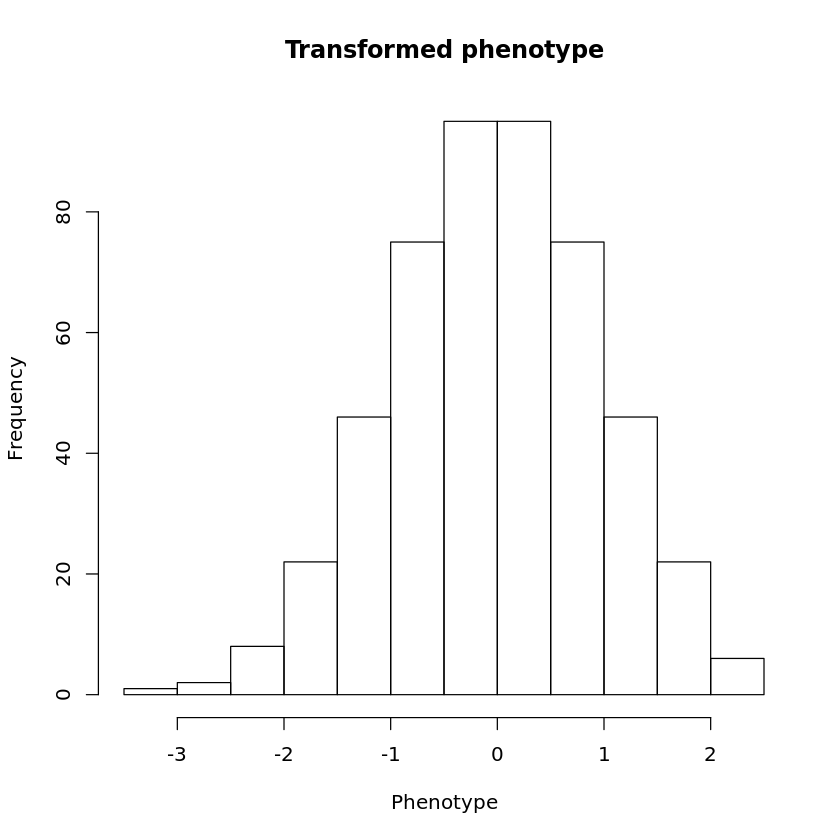

In [13]:

# we use an inverse-normal transformation to standardise our phenotype
c=3/8
d$stdnorm=qnorm((rank(d$V2,na.last="keep")-c)/(nrow(d)-2*c+1))

# let's take a look at the transformed phenotype
hist(d$stdnorm,xlab="Phenotype", main="Transformed phenotype")

<div class="alert alert-success"><b>Bonus Question:</b> What does the <code>na.last</code> parameter in the <code>rank</code> function above do? Why is it important to set it to <code>"keep"</code>?</div>

Inverse-normal transformations are one of the main ways to standardise non-normally distrubted phenotypes. More details on the formula we used above are summarised in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2921808/) paper. Setting <code>c</code> to 3/8 may seem arbitrary, and it kind of is. As discussed in the above paper under "Distinguishing among INTs", the choice of value for <code>c</code> makes very little to no difference, but 3/8 is the most common.

Now that we have transformed our phenotype, we just need to save it to a <code>Plink</code> [compatible format](https://www.cog-genomics.org/plink/1.9/input#pheno). The <code>Plink</code> pheno file is similar to a .fam file, with the first two columns being individual and family IDs; the third column should contain the phenotype values.

```
write.table(d[,.(V1,V1,stdnorm)],"cohort1_pheno_final.txt",col.names=F,row.names=F,quote=F,sep="\t")
```

## Step 2: Analysis

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step2</code> folder.</div>


<div class="alert alert-success"><b>Question 4:</b> We want to perform genetic association in our cohort with our transformed phenotype stored in the <code>cohort1_pheno_final.txt</code> file. Examine the `cohort1.*` files (do not open or try to visualise the `.bed` file, it contains binary-encoded phenotypes. If you want to examine the genotypes, convert it to a human-readable format with Plink, using `--recode`). Run the association using <code>PLINK</code> (check the `--pheno`, `--bfile` and `--assoc` flags). You can create a new Terminal in Jupyter or do it here after switching the kernel to bash again.</div>





In [1]:
cd data/Step2
ls

cohort1.bed  cohort1.bim  cohort1.fam  cohort1_pheno_final.txt


In [2]:
plink --bfile cohort1 --assoc --pheno cohort1_pheno_final.txt --out cohort1_assoc

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to cohort1_assoc.log.
Options in effect:
  --assoc
  --bfile cohort1
  --out cohort1_assoc
  --pheno cohort1_pheno_final.txt

52333 MB RAM detected; reserving 26166 MB for main workspace.
280009 variants loaded from .bim file.
498 people (240 males, 258 females) loaded from .fam.
498 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 498 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999994.
280009 variants and 498 people pass filters and QC.
Phenotype data is quantitative.
--linear).
Writing QT --assoc report to cohor

In [3]:
head cohort1_assoc.qassoc

 CHR           SNP         BP    NMISS       BETA         SE         R2        T            P 
   1      1:564862     564862      498   -0.06527     0.1576  0.0003458  -0.4142       0.6789 
   1      1:752566     752566      498    -0.1422    0.09019   0.004991   -1.577       0.1154 
   1      1:752721     752721      498    -0.1218    0.09011   0.003672   -1.352        0.177 
   1      1:798959     798959      498    -0.0086    0.07699  2.516e-05  -0.1117       0.9111 
   1      1:838555     838555      498   -0.04112    0.07517  0.0006031  -0.5471       0.5845 
   1      1:846808     846808      498    -0.1217    0.07972   0.004674   -1.526       0.1276 
   1      1:861808     861808      498    0.04349     0.2048  9.091e-05   0.2124       0.8319 
   1      1:881627     881627      498    0.03768    0.06441  0.0006895    0.585       0.5588 
   1      1:881918     881918      498     -0.158      0.137   0.002674   -1.153       0.2494 


This will produce an output file in the [`qassoc`](https://www.cog-genomics.org/plink2/formats#qassoc) format ("q" stands for quantitative, as our trait is not binary).

PLINK association reports are very readable for the human eye, but not so for other programs (mainly because Plink adds multiple spaces to display rows in an orderly fashion, rather than tabs). Let's take some time to make our file more computer-friendly.

We want to remove multiple whitespace characters and convert the file to a tab-delimited format:




In [3]:
sed 's/^ \+//g' cohort1_assoc.qassoc | head
sed 's/ \+/\t/g' cohort1_assoc.qassoc | head

CHR           SNP         BP    NMISS       BETA         SE         R2        T            P 
1      1:564862     564862      498   -0.06527     0.1576  0.0003458  -0.4142       0.6789 
1      1:752566     752566      498    -0.1422    0.09019   0.004991   -1.577       0.1154 
1      1:752721     752721      498    -0.1218    0.09011   0.003672   -1.352        0.177 
1      1:798959     798959      498    -0.0086    0.07699  2.516e-05  -0.1117       0.9111 
1      1:838555     838555      498   -0.04112    0.07517  0.0006031  -0.5471       0.5845 
1      1:846808     846808      498    -0.1217    0.07972   0.004674   -1.526       0.1276 
1      1:861808     861808      498    0.04349     0.2048  9.091e-05   0.2124       0.8319 
1      1:881627     881627      498    0.03768    0.06441  0.0006895    0.585       0.5588 
1      1:881918     881918      498     -0.158      0.137   0.002674   -1.153       0.2494 
sed: couldn't write 91 items to stdout: Broken pipe
	CHR	SNP	BP	NMISS	BETA	SE	

<div class="alert alert-info">You can use the <code>-i</code> in <code>sed</code> to modify the files in-place.</div>

### Additional information

It is useful to add other columsn to the .qassoc file, such as alleles and allele frequencies. This is not only good for future reference, but also important for subsequent meta-analysis.

To get allele frequencies, we again run Plink:




In [4]:
plink --bfile cohort1 --freq --out cohort1_maf

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to cohort1_maf.log.
Options in effect:
  --bfile cohort1
  --freq
  --out cohort1_maf

52333 MB RAM detected; reserving 26166 MB for main workspace.
280009 variants loaded from .bim file.
498 people (240 males, 258 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 498 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999994.
--freq: Allele frequencies (founders only) written to cohort1_maf.frq .



This produces a [.frq](https://www.cog-genomics.org/plink/1.9/formats#frq) file. Similar to the .qassoc file, we want to remove redundant whitespace characters and change the delimiter to tabs.



In [6]:
head cohort1_maf.frq

 CHR           SNP   A1   A2          MAF  NCHROBS
   1      1:564862    C    T      0.04418      996
   1      1:752566    G    A       0.1586      996
   1      1:752721    A    G       0.1596      996
   1      1:798959    A    G       0.2028      996
   1      1:838555    A    C        0.238      996
   1      1:846808    T    C       0.1847      996
   1      1:861808    A    G       0.0251      996
   1      1:881627    G    A       0.3655      996
   1      1:881918    A    G      0.05522      996


```bash
sed -i 's/^ \+//g' cohort1_maf.frq
sed -i 's/ \+/\t/g' cohort1_maf.frq
```

**N.B.:** For Plink, "A1" is usually the minor allele and also set as the risk allele.

Next, we add this information to the association summary statistics together with the alleles, which we get from the .fam file.

```bash
join -1 2 -2 1 <(sort -k2,2 cohort1_assoc.qassoc) <(cut -f2,5,6 cohort1.bim | sort -k1,1) | sed -e 's/ \+/\t/g' > temp

cat <(echo -e "SNP CHR BP NMISS BETA SE R2 T P A1 A2 AF_A1") <(join -1 1 -2 1 <(sort -k1,1 temp) <(cut -f2,5 cohort1_maf.frq | sort -k1,1)) | sed -e 's/ \+/\t/g' > temp2

mv temp2 cohort1_assoc.qassoc
rm temp
```

<hr>

## Step 3: Visualisation of results

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step3</code> folder.</div>


Now that you have run the association, you will want to see whether there are any significant associations in your data.
There are two main plots generated after an association run:

* **The Quantile-Quantile (QQ)** plot is essentially a diagnostic plot. It compares the distribution of p-values against a uniform (expected) distribution. Any deviation from the expected is indicative of an issue (sample relatedness, population stratification, non-normality of phenotype values, etc...). If the associaiton p-values are systematically lower (i.e. more significant) than expected, we refer to this as "inflation".
* **The Manhattan Plot** displays the $-log_{10}$ of the SNP p-values across the genome and allows to easily spot signals (peaks).


<br>

<div class="alert alert-success"><b>Question 4:</b>  In R, use the <code>fread</code> function from the <code>data.table</code> package to read the file. Plot a QQ-plot for the association p-values using <code>qqunif</code> from the <code>gap</code> package or <code>qq</code> from the <code>qqman</code> package. If you are running this in the notebook, don't forget to switch kernels again.</div>


<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>


For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).



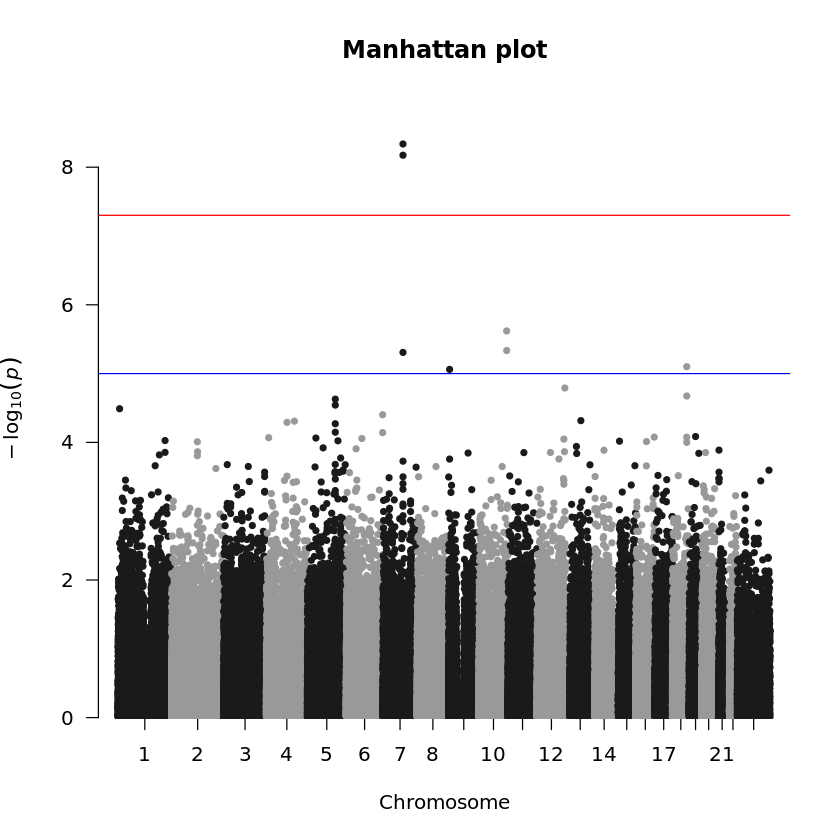

In [1]:

library(data.table)
library(qqman)
d=fread("data/Step3/cohort1_assoc.qassoc")
manhattan(d,main="Manhattan plot")


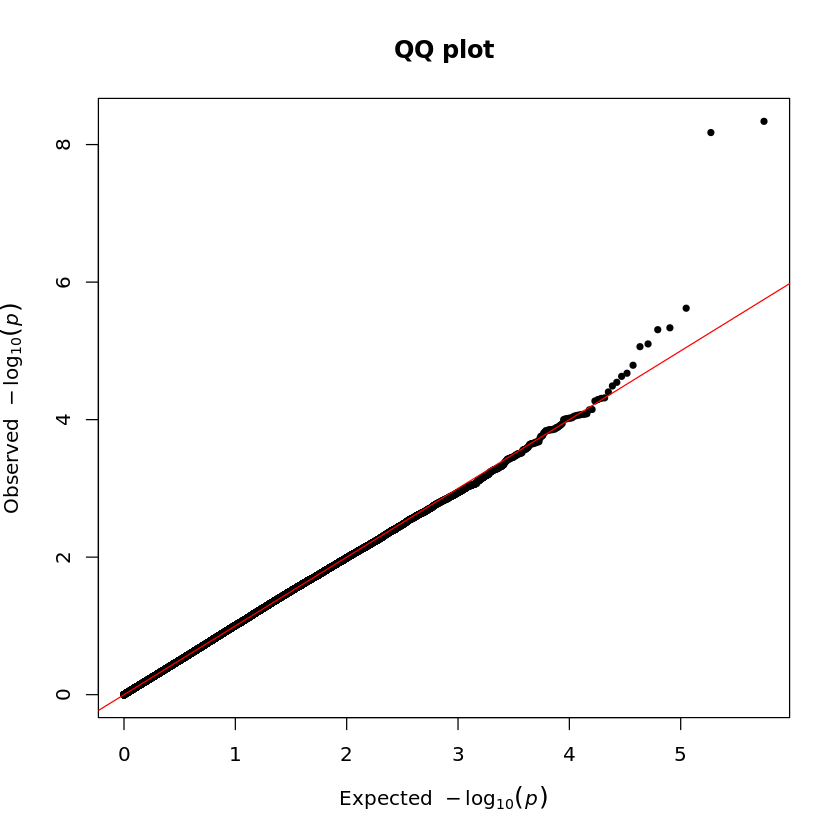

In [2]:
qq(d$P, main="QQ plot")

The <code>qqman</code> package provides quick and useful functions to plot GWAS results. However, the code can be a bit clunky if you want to customise your Manhattan plots. 

<br>

<div class="alert alert-success"><b>Bonus Question:</b> Try to create a Manhattan plot using only base graphics.</div>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>

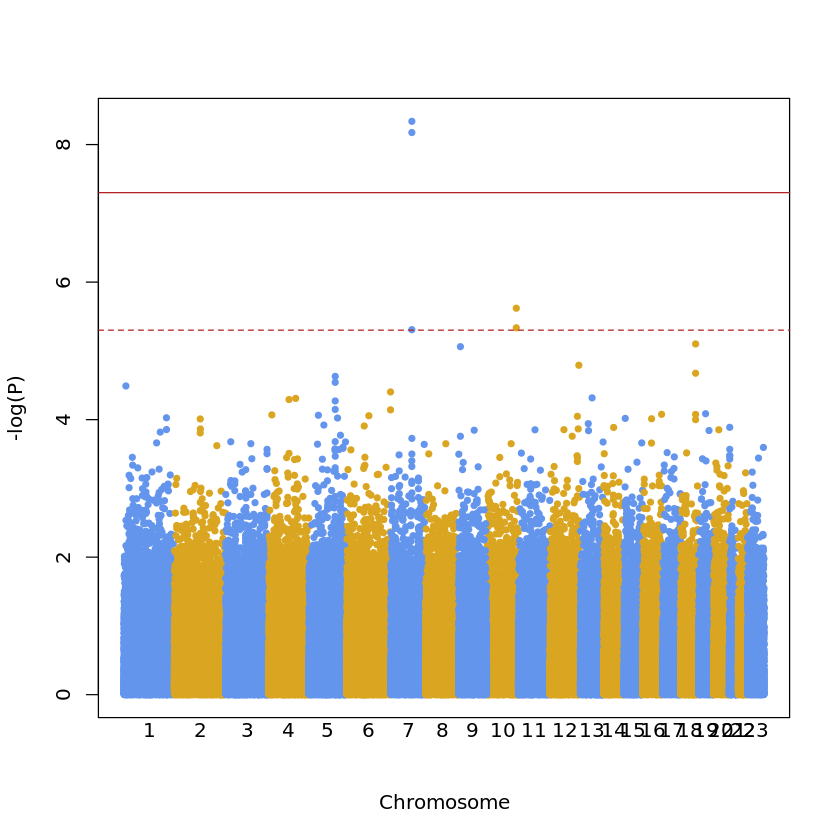

In [4]:
d=fread("data/Step3/cohort1_assoc.qassoc")

## Define colors for each chromosome 
## (a list is available at www.stat.columbia.edu/~tzheng/files/Rcolor.pdf)
colors=c(rep(c("cornflowerblue", "goldenrod"),11),"cornflowerblue")

## We must create a column with continuous basepair positions from chr1 to chr23,
## otherwise we won't be able to plot one continuous x-axis
d[CHR==1,BP2:=rank(BP)]
pos=function(x) { rank(d[CHR==x]$BP)+max(d[CHR==(x-1)]$BP2) }
for(i in 2:23) {
    d[CHR==i, BP2:=pos(i)]
}

## Generate the plot
plot(x=d$BP2, y=-log(d$P, base=10), pch=20, col=colors[d$CHR], 
     ylab="-log(P)", xlab="Chromosome", xaxt="n")

## Add chromosome legends
ticks=unlist( lapply(1:23, function(x) median(d[CHR==x]$BP2)) )
mtext(seq(1,23), side=1, at=ticks)


## We draw lines at genome-wide and suggestive significance levels
abline(h=-log(5e-8, base=10), col="firebrick") # only shows if there are values that exceed that line on the y-axis
abline(h=-log(5e-6, base=10), col="firebrick", lty=2)

### What are the peaks?

From our Manhattan plot we can see that there is one locus reaching genome-wide signifcance (p<5*10e-8) on chromosome 7.

The next step is to investigate what this locus is. In practice, annotation and follow-up of signals is the main difficulty in GWAS, the analysis is actually quite easy! For now, let's take a closer look at our results:

This command sorts the results by p-value and displays the first few lines of the sorted file (switch to bash again).



In [2]:
sort -g -k9,9 data/Step3/cohort1_assoc.qassoc | head

SNP	CHR	BP	NMISS	BETA	SE	R2	T	P	A1	A2	AF_A1
rs9641123	7	93197732	491	0.3703	0.06204	0.06791	5.969	4.596e-09	C	G	0.4026
7:93163719	7	93163719	491	0.3665	0.06209	0.06651	5.903	6.691e-09	T	C	0.3735
10:129182308	10	129182308	491	-0.3369	0.07057	0.04452	-4.773	2.399e-06	A	G	0.2771
10:129186924	10	129186924	491	-0.3695	0.07975	0.04205	-4.633	4.622e-06	A	G	0.2108
7:93186244	7	93186244	491	-0.2864	0.062	0.04182	-4.62	4.922e-06	A	G	0.4137
18:66664946	18	66664946	491	-0.943	0.2089	0.04002	-4.515	7.935e-06	G	A	0.02309
9:4716078	9	4716078	491	0.3393	0.07548	0.03968	4.495	8.695e-06	T	G	0.2289
12:129341226	12	129341226	491	-0.495	0.1137	0.03734	-4.355	1.619e-05	A	G	0.07932
18:66649810	18	66649810	491	-0.9178	0.2137	0.03634	-4.294	2.116e-05	C	A	0.02209
sort: write failed: 'standard output': Broken pipe
sort: write error


<div class="alert alert-success"><b>Question 5:</b> What is the identifier of the top SNP? What is its direction of effect, its MAF, chromosome position and its alleles?</div>

### Regional plot

It's a good idea to generate a regional plot of the signal you get (especially if you're going to publish your results).

One way to do this is to use [LocusZoom](http://locuszoom.org/), which is a web interface for creating regional, LD-annotated association plots.

However, as for the Manhattan plots, it can be useful to know how to generate a regional plot from scratch. You can annotate this plot with information like protein coding genes, which you can download from databases like [Ensembl](http://www.ensembl.org/index.html).

Since you don't want to download gene information for the entire genome, we're going to restrict it to the region of the plot. A good starting point is ±1Mb around your top SNP (although you can of course zoom in or out).

<br>
<div class="alert alert-success"><b>Question 6:</b> From Question 5 you will know that our SNP's position is 93197732 in build GRCh37. Calculate the start and end coordinates of our regional window in using <code>bash</code>.</div>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show answer.</button>

In [4]:
# start position
echo The start position is $((93197732 - 1000000)).

# end position
echo The end position is $((93197732 + 1000000)).

The start position is 92197732.
The end position is 94197732.


We want to see which genes are close to our signal. So we're going to download coordinate information for protein coding genes from a very useful database called Ensembl. It is a very useful resource, and often the starting point for every genetic follow-up. They provide a very useful [Ensmebl Rest API](https://rest.ensembl.org/), which we are going to use. We could also download a list of genes and coordinates, and process the file from the command line.

<div class="alert alert-warning">We need a reference coordinate system to map identifiers (such as a gene name or RS-id) to physical positions. This is called a genomic build. It is very important to know which build your genetic information is on. In our case, it's build 37, which is rather old (but everyone keeps using it for convenience). but the default Ensembl Rest API uses GRCh38. We can use an archive version of the Rest API to access GRCh37 coordinates. </div>

The below command downloads data in a [JSON]("https://en.wikipedia.org/wiki/JSON") file from the given link, then parses the file to select only protein-coding transcripts, and outputs the gene name, chromosome, start and stop position. If you want to look at the raw output, you can check it out by [executing the GET request directly in your browser](http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json).





In [5]:
wget -O - --no-check-certificate "http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json" | jq

--2019-06-17 15:03:29--  http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json
Resolving grch37.rest.ensembl.org (grch37.rest.ensembl.org)... 193.62.193.83
Connecting to grch37.rest.ensembl.org (grch37.rest.ensembl.org)|193.62.193.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9325 (9.1K) [application/json]
Saving to: ‘STDOUT’

-                   100%[===================>]   9.11K  --.-KB/s    in 0s      

2019-06-17 15:03:30 (257 MB/s) - written to stdout [9325/9325]

[
  {
    "id": "ENSG00000234545",
    "end": 92219708,
    "biotype": "protein_coding",
    "gene_id": "ENSG00000234545",
    "logic_name": "ensembl_havana_gene",
    "external_name": "FAM133B",
    "feature_type": "gene",
    "source": "ensembl_havana",
    "strand": -1,
    "version": 3,
    "assembly_name": "GRCh37",
    "description": "family with sequence similarity 133, member B [Source:HGNC Symbol;Acc:28629]",
    "seq_regi

As you see, the result request is quite long, we are going to restrict it to protein coding genes, which we are interested in, and only extract the fields we want:

In [8]:
wget -O - --no-check-certificate "http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json" | jq -r '.[] | select(.biotype == "protein_coding") | "\(.external_name) \(.seq_region_name) \(.start) \(.["end"])"' | head

--2019-06-17 15:07:54--  http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json
Resolving grch37.rest.ensembl.org (grch37.rest.ensembl.org)... 193.62.193.83
Connecting to grch37.rest.ensembl.org (grch37.rest.ensembl.org)|193.62.193.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9325 (9.1K) [application/json]
Saving to: ‘STDOUT’

-                   100%[===================>]   9.11K  --.-KB/s    in 0s      

2019-06-17 15:07:55 (240 MB/s) - written to stdout [9325/9325]

FAM133B 7 92190107 92219708
CDK6 7 92234235 92465908
SAMD9 7 92728829 92747336
SAMD9L 7 92759368 92777682
HEPACAM2 7 92817899 92855837
CCDC132 7 92861653 92988338
CALCR 7 93053799 93204042
GNGT1 7 93220885 93540577
TFPI2 7 93514709 93520303
GNG11 7 93551011 93557922


Then we can generate a file:

```bash
wget -O - --no-check-certificate "http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json" | jq -r '.[] | select(.biotype == "protein_coding") | "\(.external_name) \(.seq_region_name) \(.start) \(.["end"])"' > ensembl_genes.txt
```


Using this information, we can now create a gene-annotated regional plot in R (switch to R kernel).

<br>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>

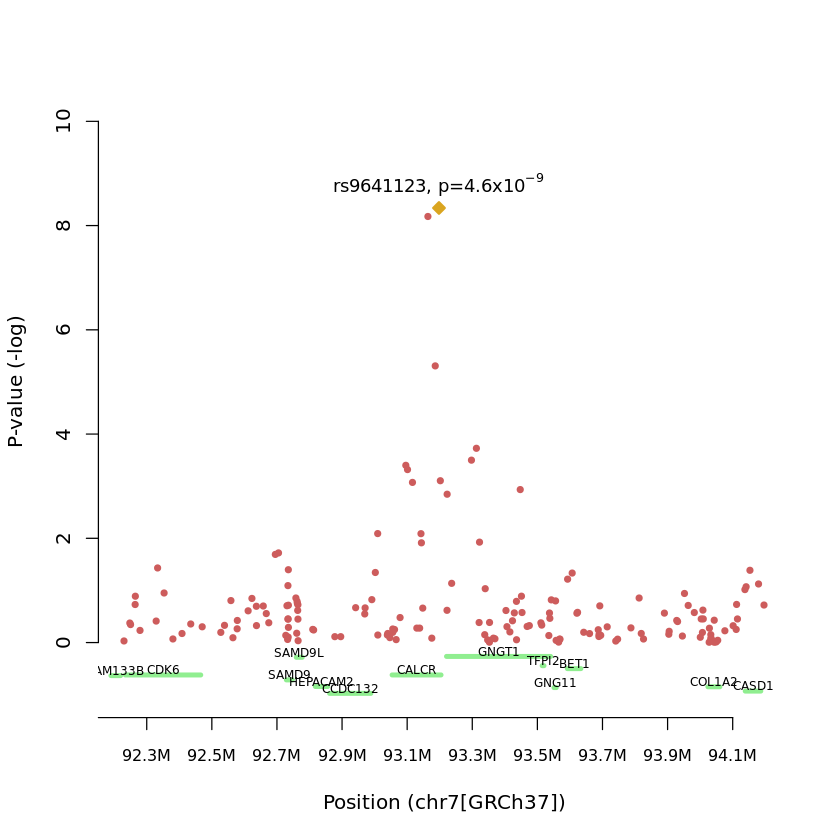

In [1]:
library(data.table)
# Load the data and subset it to our region of itnerest
d=fread("data/Step3/cohort1_assoc.qassoc")
d=d[CHR==7 & BP<(d[SNP=="rs9641123",]$BP+1000000) & BP>(d[SNP=="rs9641123",]$BP-1000000)]

# read in the gene positions and create y-coordinates for them to be plotted under the association signals
# (this will make sense once you look at the plot...)
g=fread("ensembl_genes.txt")
gpos=runif(nrow(g), min=-0.99, max=-0.25)

# Create the plot
plot(x=d$BP, y=-log(d$P, base=10), ylim=c(-1,10), pch=20, col="indianred", axes=F, xlab="", ylab="")

# Add axes and labels
axis(2, at=seq(0, 10, by=2), labels=seq(0, 10, by=2))
mtext("P-value (-log)", side=2, at=5, line=3)
axis(side=1, at=seq(92.1, 94.1, by=0.2)*1000000, labels=paste0(seq(92.1, 94.1, by=0.2), "M"),cex.axis=0.8)
mtext("Position (chr7[GRCh37])", side=1, line=3)

# Highlight the top SNP
points(x=d[SNP=="rs9641123",]$BP, y=-log(d[SNP=="rs9641123"]$P, base=10), col="goldenrod", pch=23, bg="goldenrod", lwd=2)
text(x=93197732, y=-log(4.596e-09, base=10), labels=bquote("rs9641123, p=4.6x10"^-09), pos=3, cex=0.9)

# Plot genes as segments below the association signals
segments(y0=gpos, x0=g$V3, x1=g$V4, lwd=4, col="lightgreen")
text(x=(g$V3+g$V4)/2,y=gpos+0.1,labels=g$V1, cex=0.6)


It looks like rs9641123 lies within the *CALCR* gene. You can now look at whether this association is known, and what the _CALCR_ gene does, on the Ensembl database.


<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [3]:
%load_ext rpy2.ipython